In [1]:
import os
import numpy as np
import torch.nn as nn
import torch
import random
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset
from matplotlib import pyplot as plt

BASE_DIR = os.path.dirname(os.getcwd())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
BASE_DIR

'C:\\Users\\Alvin\\Desktop\\sota_net\\02VGG\\VGG-代码\\B_VGG'

In [2]:
# config
num_classes = 2

MAX_EPOCH = 3
BATCH_SIZE = 128
LR = 0.001
log_interval = 1
val_interval = 1
classes = 2
start_epoch = -1
lr_decay_step = 1

# 1. 数据集

18
2
tensor([[[0.7922, 0.8157, 0.8275,  ..., 0.8000, 0.8039, 0.8039],
         [0.8078, 0.8118, 0.8353,  ..., 0.7922, 0.7882, 0.7882],
         [0.8431, 0.8588, 0.8588,  ..., 0.8157, 0.8235, 0.8314],
         ...,
         [0.0980, 0.0902, 0.0941,  ..., 0.5647, 0.5725, 0.5725],
         [0.0784, 0.0863, 0.0941,  ..., 0.5569, 0.5725, 0.5804],
         [0.0706, 0.0784, 0.0902,  ..., 0.5647, 0.5765, 0.5843]],

        [[0.7725, 0.8078, 0.8275,  ..., 0.7137, 0.7176, 0.7176],
         [0.7843, 0.8039, 0.8353,  ..., 0.7137, 0.7137, 0.7098],
         [0.8235, 0.8510, 0.8627,  ..., 0.7490, 0.7569, 0.7647],
         ...,
         [0.1882, 0.1843, 0.1804,  ..., 0.1961, 0.1922, 0.1843],
         [0.1451, 0.1490, 0.1529,  ..., 0.1922, 0.1882, 0.1804],
         [0.1020, 0.1059, 0.1098,  ..., 0.1843, 0.1804, 0.1725]],

        [[0.7765, 0.8235, 0.8431,  ..., 0.7373, 0.7490, 0.7608],
         [0.7843, 0.8157, 0.8510,  ..., 0.7294, 0.7373, 0.7490],
         [0.8196, 0.8549, 0.8706,  ..., 0.7686, 0.784

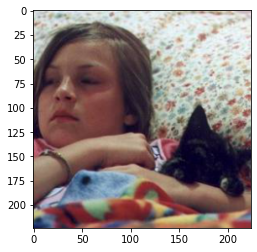

In [3]:
def transform_invert(img_, transform_train):
    """
    将data 进行反transfrom操作
    :param img_: tensor
    :param transform_train: torchvision.transforms
    :return: PIL image
    """
    if 'Normalize' in str(transform_train):
        norm_transform = list(filter(lambda x: isinstance(x, transforms.Normalize), transform_train.transforms))
        mean = torch.tensor(norm_transform[0].mean, dtype=img_.dtype, device=img_.device)
        std = torch.tensor(norm_transform[0].std, dtype=img_.dtype, device=img_.device)
        img_.mul_(std[:, None, None]).add_(mean[:, None, None])

    img_ = img_.transpose(0, 2).transpose(0, 1)  # C*H*W --> H*W*C
    if 'ToTensor' in str(transform_train):
        img_ = np.array(img_) * 255

    if img_.shape[2] == 3:
        img_ = Image.fromarray(img_.astype('uint8')).convert('RGB')
    elif img_.shape[2] == 1:
        img_ = Image.fromarray(img_.astype('uint8').squeeze())
    else:
        raise Exception("Invalid img shape, expected 1 or 3 in axis 2, but got {}!".format(img_.shape[2]) )

    return img_

class CatDogDataset(Dataset):
    def __init__(self, data_dir, mode="train", split_n=0.9, rng_seed=620, transform=None):
        """
        rmb面额分类任务的Dataset
        :param data_dir: str, 数据集所在路径
        :param transform: torch.transform，数据预处理
        """
        self.mode = mode
        self.data_dir = data_dir
        self.rng_seed = rng_seed
        self.split_n = split_n
        self.data_info = self._get_img_info()  # data_info存储所有图片路径和标签，在DataLoader中通过index读取样本
        self.transform = transform

    def __getitem__(self, index):
        path_img, label = self.data_info[index]
        img = Image.open(path_img).convert('RGB')     # 0~255

        if self.transform is not None:
            img = self.transform(img)   # 在这里做transform，转为tensor等等

        return img, label

    def __len__(self):
        if len(self.data_info) == 0:
            raise Exception("\ndata_dir:{} is a empty dir! Please checkout your path to images!".format(self.data_dir))
        return len(self.data_info)

    def _get_img_info(self):

        img_names = os.listdir(self.data_dir)
        img_names = list(filter(lambda x: x.endswith('.jpg'), img_names)) # 获取所有图片文件名

        random.seed(self.rng_seed)  # 保证每次随机的顺序一致，避免训练集与测试集有交叉
        random.shuffle(img_names)

        img_labels = [0 if n.startswith('cat') else 1 for n in img_names]  # 根据文件名获取标签

        split_idx = int(len(img_labels) * self.split_n) # 25000* 0.9 = 22500  # 选择划分点 
        # split_idx = int(100 * self.split_n)
        if self.mode == "train":
            img_set = img_names[:split_idx]     # 数据集90%训练
            label_set = img_labels[:split_idx]
        elif self.mode == "valid":
            img_set = img_names[split_idx:]
            label_set = img_labels[split_idx:]
        else:
            raise Exception("self.mode 无法识别，仅支持(train, valid)")

        path_img_set = [os.path.join(self.data_dir, n) for n in img_set]  # 拼接路径
        data_info = [(n, l) for n, l in zip(path_img_set, label_set)]     # 制作样本对

        return data_info

norm_mean = [0.485, 0.456, 0.406]  # imagenet 训练集中统计得来
norm_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((256)),      # (256, 256) 区别
    transforms.CenterCrop(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

normalizes = transforms.Normalize(norm_mean, norm_std)
valid_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.TenCrop(224, vertical_flip=False),
    transforms.Lambda(lambda crops: torch.stack([normalizes(transforms.ToTensor()(crop)) for crop in crops])),
])

# dataset
# data_dir = os.path.join(BASE_DIR, "data", "train")
# train_data = CatDogDataset(data_dir=data_dir, mode="train", transform=train_transform)
# valid_data = CatDogDataset(data_dir=data_dir, mode="valid", transform=valid_transform)
# print(train_data.__len__()) 
# print(valid_data.__len__())


# fake dataset
fake_dir = os.path.join(BASE_DIR,  "data", "fake_dataset")
train_data = CatDogDataset(data_dir=fake_dir, mode="train", transform=train_transform)
valid_data = CatDogDataset(data_dir=fake_dir, mode="valid", transform=valid_transform)
print(train_data.__len__()) 
print(valid_data.__len__())


img_tensor, label = train_data.__getitem__(1)

img_rgb = transform_invert(img_tensor, train_transform)
print(img_tensor, label)
print(img_rgb)
plt.imshow(img_rgb)


In [4]:
# 构建DataLoder
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True) # 20  128
valid_loader = DataLoader(dataset=valid_data, batch_size=4) # 2 4

print(BATCH_SIZE)
print(len(train_loader))
print(len(valid_loader))

128
1
1


# 2. 构建VGG模型

In [5]:
import torchvision.models as models

def get_vgg16(path_state_dict, device, vis_model=False):
    """
    创建模型，加载参数
    :param path_state_dict:
    :return:
    """
    model = models.vgg16()
    pretrained_state_dict = torch.load(path_state_dict)
    model.load_state_dict(pretrained_state_dict)
    model.eval()

    if vis_model:
        from torchsummary import summary
        summary(model, input_size=(3, 224, 224), device="cpu")

    model.to(device)
    return model
# ============================ step 2/5 模型 ============================
path_state_dict = os.path.join(BASE_DIR, "Data", "vgg16-397923af.pth")
vgg16_model = get_vgg16(path_state_dict, device, False)

num_ftrs = vgg16_model.classifier._modules["6"].in_features
vgg16_model.classifier._modules["6"] = nn.Linear(num_ftrs, num_classes)

print(num_ftrs)
vgg16_model.to(device)
print(vgg16_model)

4096
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

In [6]:
vgg16_model.features[0]  # vgg16网络第一层

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [7]:
vgg16_model.features[0].weight.shape # 64个3*3*3的卷积核

torch.Size([64, 3, 3, 3])

# 3. 损失函数和优化器

In [8]:
# ============================ step 3/5 损失函数 ============================
criterion = nn.CrossEntropyLoss()
# ============================ step 4/5 优化器 ============================
# 冻结卷积层
flag = 0
# flag = 1
# 通过控制flag的方法让卷积部分的学习率小一点，让classifier的学习率大一点
if flag:
    fc_params_id = list(map(id, vgg16_model.classifier.parameters()))  # 返回的是parameters的 内存地址
    base_params = filter(lambda p: id(p) not in fc_params_id, alexnet_model.parameters())
    optimizer = optim.SGD([
        {'params': base_params, 'lr': LR * 0.1},  # 0           
        {'params': vgg16_model.classifier.parameters(), 'lr': LR}], momentum=0.9)

else:
    optimizer = optim.SGD(vgg16_model.parameters(), lr=LR, momentum=0.9)  # 选择优化器

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step, gamma=0.1)  # 设置学习率下降策略
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(patience=5)

print(optimizer)
print(scheduler)



SGD (
Parameter Group 0
    dampening: 0
    initial_lr: 0.001
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


# 4. 迭代训练

In [14]:
# ============================ step 5/5 训练 ============================
if str(device) == 'cuda':
    print('Currently Using GPU for training')
else:
    print('Currently Using CPU for training')
for epoch in range(0, 1):

    loss_mean = 0.
    correct = 0.
    total = 0.

    vgg16_model.train()
    for i, data in enumerate(train_loader):

        # 1. forward
        inputs, labels = data
        print(inputs, inputs.shape, labels, labels.shape)

        fake_inputs = torch.randn((1,3, 224, 224), device=device)
        fake_labels = torch.ones((1,), dtype=torch.int64, device=device)
        
        outputs = vgg16_model(fake_inputs)

        # 2. backward
        optimizer.zero_grad()
        loss = criterion(outputs, fake_labels)
        loss.backward()

        # 3. update weights
        optimizer.step()
        
    
        print(outputs)
        print(loss.item())
        
        
    scheduler.step()  # 更新学习率
    

  

Currently Using GPU for training
tensor([[[[ 1.7009,  1.7865,  1.8893,  ...,  0.5022,  0.7419,  0.9646],
          [ 1.8379,  1.8037,  1.7865,  ...,  0.5707,  0.6049,  0.7591],
          [ 1.9578,  1.8550,  1.7694,  ...,  0.8789,  0.7248,  0.6221],
          ...,
          [-0.1657, -0.1486, -0.0972,  ..., -0.5767, -0.5938, -0.6965],
          [-0.2171, -0.1828, -0.1143,  ..., -0.5253, -0.4911, -0.5938],
          [-0.2342, -0.1828, -0.1314,  ..., -0.5938, -0.5596, -0.6109]],

         [[ 1.9209,  2.0084,  2.1835,  ...,  0.7304,  0.9580,  1.1681],
          [ 2.0784,  2.0784,  2.1134,  ...,  0.7829,  0.8004,  0.9580],
          [ 2.2010,  2.1310,  2.1134,  ...,  1.0630,  0.9055,  0.8179],
          ...,
          [ 0.4153,  0.4153,  0.4153,  ..., -1.5105, -1.4580, -1.4405],
          [ 0.3627,  0.3803,  0.4153,  ..., -1.4580, -1.3880, -1.3880],
          [ 0.3452,  0.3627,  0.3978,  ..., -1.5105, -1.4405, -1.4405]],

         [[ 2.0125,  2.1346,  2.3611,  ...,  0.5659,  0.9145,  1.2631

tensor([[-1.8068,  0.5589]], device='cuda:0', grad_fn=<AddmmBackward>)
0.08973531424999237
